In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
import meteostat


In [30]:
def generate_contigency_tables(
    go_annotations, gene_list, use_background_genes=False, background_genes=[]
):
    """Takes list of Go Annotations as a binary matrix with Genes as the index and GO terms as columns, and a list of genes, and
    generates the contigency tables on which to run a Fisher Exact Test for enrichment.
    Args:
        go_annotations (Panda DataFrame): Binary Matrix, with genes as index and GO Terms as colummns. Generated by Go_annotations function (may not
        work for non plant species idk check the code for it its been a while)
        gene_list (list): What is says on the tin
    """

    if use_background_genes == True:
        go_annotations = go_annotations.loc[
            go_annotations.index.intersection(background_genes)
        ]

    gene_list = list(set(go_annotations.index) & set(gene_list))
    background_distribution_num_genes_annotated_with_go_term = go_annotations.sum(
        axis=0
    )
    background_dipstribution_num_genes_that_lack_go_term = (
        go_annotations.shape[0]
        - background_distribution_num_genes_annotated_with_go_term
    )
    annotation_subset_to_genes_in_list = go_annotations.loc[gene_list]
    go_subset_distribution_num_genes_annotatated_with_go_term = (
        annotation_subset_to_genes_in_list.sum(axis=0)
    )
    go_subset_distribution_num_genes_that_lack_go_term = (
        annotation_subset_to_genes_in_list.shape[0]
        - go_subset_distribution_num_genes_annotatated_with_go_term
    )

    all_go_contingency_tables = []
    i = 0
    for term_of_go in background_distribution_num_genes_annotated_with_go_term:
        contig_table = [
            [
                (
                    term_of_go
                    - go_subset_distribution_num_genes_annotatated_with_go_term[i]
                ),
                go_subset_distribution_num_genes_annotatated_with_go_term[i],
            ],
            [
                (
                    background_dipstribution_num_genes_that_lack_go_term[i]
                    - go_subset_distribution_num_genes_that_lack_go_term[i]
                ),
                go_subset_distribution_num_genes_that_lack_go_term[i],
            ],
        ]
        all_go_contingency_tables.append(contig_table)
        i += 1
    return all_go_contingency_tables


def fishers_exact_on_contigency_tables(
    all_go_contigency_tables, original_GO_term_panda, return_odds_ratio=False
):
    """Takes Table from generate_contigency_tables and runs fishers exact on all the tables, without correcting the P-values. Returns
    either just a Panda with the p values, or a Panda of lists for odds ratios, P values, just like stats.fisher_exact. If you're wondering if
    you want the Odds Ratios, you don't want them

    Args:
        all_go_contigency_tables (list): Contigency Tables formatted as list of lists from generate_contigency_tables
        return_odds_ratio (bool): Boolean for if you want it to return both the odds ratios and the P values or just the P Values. Defaults to just the
        P Values
        original_GO_term_panda (Panda DataFrame):  Binary Matrix, with genes as index and GO Terms as colummns. Generated by Go_annotations function (may not
        work for non plant species idk check the code for it its been a while)  Same as above
    """
    import scipy.stats as stats
    import pandas as pd

    list_of_p_values_for_go_terms = []
    list_of_odds_ratios_for_go_terms = []

    for table in all_go_contigency_tables:
        odds, p_value = stats.fisher_exact(table=table, alternative="less")
        list_of_p_values_for_go_terms.append(p_value)
        list_of_odds_ratios_for_go_terms.append(odds)

    if return_odds_ratio == True:

        go_terms_with_P_value_and_odds = pd.DataFrame(
            data=list(
                zip(list_of_p_values_for_go_terms, list_of_odds_ratios_for_go_terms)
            ),
            index=original_GO_term_panda.columns,
            columns=["P_value", "Odds Ratios"],
        )
        return go_terms_with_P_value_and_odds

    if return_odds_ratio == False:

        go_terms_with_P_value = pd.DataFrame(
            data=list_of_p_values_for_go_terms,
            index=original_GO_term_panda.columns,
            columns=["P_value"],
        )
        return go_terms_with_P_value


def multi_hypothesis_correct_fishers_exact(
    go_terms_with_P_value,
    alpha=0.05,
    method="indep",
    is_sorted=False,
    panda_has_odds_ratio=False,
    Include_rejected_boolean_array=False,
):
    """Runs Multiple Hypothesis Testing via statsmodels.stats.multitest.fdrcorrection. Takes all values for that, as well as Panda of go terms from previous step

    Args:
        go_terms_with_P_value (Panda Dataframe): Pandas Dataframe from fishers_exact_on_contigency_tables
        alpha (float): Familywise error rate, defaults to 0.05
        method (str): Which method to use for FDR correction. {'i', 'indep', 'p', 'poscorr'} all refer to fdr_bh (Benjamini/Hochberg for independent or positively correlated tests).
         {'n', 'negcorr'} both refer to fdr_by (Benjamini/Yekutieli for general or negatively correlated tests). Defaults to 'indep'.
        is_sorted (bool): _f False (default), the p_values will be sorted, but the corrected pvalues are in the original order. If True, then it assumed that the pvalues are already sorted in ascending order.
        panda_has_odds_ratio (bool): Did you ignore my previous Docstring in fishers_exact_on_contigency_tables and add the odds ratio? If so this fixes
        your foolishness and drops that column
        Include_rejected_boolean_array (bool): Makes function return a tuple of a boolean array of if a hypothesis was rejected, and the normal Panda of corrected_p_values. Don't do this just use your eyes
    """
    import statsmodels.stats.multitest
    import pandas as pd

    if panda_has_odds_ratio == True:
        go_terms_with_P_value = go_terms_with_P_value[["P_value"]]

    rejected, corrected_pvalues = statsmodels.stats.multitest.fdrcorrection(
        pvals=go_terms_with_P_value["P_value"].to_list(),
        alpha=alpha,
        method=method,
        is_sorted=is_sorted,
    )
    corrected_pvalues = corrected_pvalues.tolist()
    go_enrichment_results = pd.DataFrame(
        corrected_pvalues, index=go_terms_with_P_value.index, columns=["P_value"]
    )

    if Include_rejected_boolean_array == True:
        return rejected, go_enrichment_results

    if Include_rejected_boolean_array == False:
        return go_enrichment_results


def test_using_kwargs(
    go_terms_with_P_value,
    panda_has_odds_ratio=False,
    Include_rejected_boolean_array=False,
    **kwargs
):
    """Runs Multiple Hypothesis Testing via statsmodels.stats.multitest.fdrcorrection. Takes all values for that, as well as Panda of go terms from previous step

    Args:
        go_terms_with_P_value (Panda Dataframe): Pandas Dataframe from fishers_exact_on_contigency_tables
        kwargs : Refer to statsmodels.stats.multitest.fdrcorrection for kwargs
        alpha (float): Familywise error rate, defaults to 0.05
        method (str): Which method to use for FDR correction. {'i', 'indep', 'p', 'poscorr'} all refer to fdr_bh (Benjamini/Hochberg for independent or positively correlated tests).
         {'n', 'negcorr'} both refer to fdr_by (Benjamini/Yekutieli for general or negatively correlated tests). Defaults to 'indep'.
        is_sorted (bool): _f False (default), the p_values will be sorted, but the corrected pvalues are in the original order. If True, then it assumed that the pvalues are already sorted in ascending order.
        panda_has_odds_ratio (bool): Did you ignore my previous Docstring in fishers_exact_on_contigency_tables and add the odds ratio? If so this fixes
        your foolishness and drops that column
        Include_rejected_boolean_array (bool): Makes function return a tuple of a boolean array of if a hypothesis was rejected, and the normal Panda of corrected_p_values. Don't do this just use your eyes
    """
    import statsmodels.stats.multitest
    import pandas as pd

    if panda_has_odds_ratio == True:
        go_terms_with_P_value = go_terms_with_P_value[["P_value"]]

    rejected, corrected_pvalues = statsmodels.stats.multitest.fdrcorrection(
        pvals=go_terms_with_P_value["P_value"].to_list(), **kwargs
    )
    go_enrichment_results = pd.DataFrame(
        corrected_pvalues, index=go_terms_with_P_value.index, columns=["P_value"]
    )

    if Include_rejected_boolean_array == True:
        return rejected, go_enrichment_results

    if Include_rejected_boolean_array == False:
        return go_enrichment_results

In [31]:
total_load_df = pd.read_csv('/Users/michael/Data/Luke_terrace_experiment/Microbiome/lic2024_ham_16S_ITS.csv', index_col=0)
total_load_df['ham16s'].min()


np.float64(0.031392277453923)

In [32]:
transcriptome = pd.read_csv(
    "/Users/michael/Data/Luke_terrace_experiment/General_data/plate1_4_tpm_normalized.csv",
    index_col=0,
)
rows_to_drop_expression_data = [
    "A2450525897_n01_undetermined",
    "A2449446903_n01_undetermined",
    "B250508004_n01_undetermined",
    "B2449500127_n01_undetermined",
]
transcriptome = transcriptome.drop(index=rows_to_drop_expression_data)
transcriptome = transcriptome.sort_index()

In [33]:
metadata = pd.read_csv(
    "/Users/michael/Data/Luke_terrace_experiment/General_data/Plates_1_to_4_metadata_merged_luke.csv",
    index_col=0,
)
metadata = metadata.drop(
    columns=[
        "arb.sort",
        "sample-id",
        "Ambiguous Unstranded",
        "Ambiguous Forward",
        "Multimapping",
        "Unmapped Over Mapped",
    ]
)
metadata["Date and Time"] = metadata["date"] + " " + metadata["time"]
luke_time_data_format = "%-m/%-d/%y %-H:%-M"
metadata["Date and Time"] = pd.to_datetime(
    metadata["Date and Time"], format=luke_time_data_format
)

In [34]:
unusable_samples = [
    "A2450525897_n01_LICRNA01_A06",
    "A2450525897_n01_LICRNA01_A08",
    "A2450525897_n01_LICRNA01_C11",
    "A2450525897_n01_LICRNA01_D11",
    "A2450525897_n01_LICRNA01_D12",
    "A2449446903_n01_LICRNA02_F01",
    "B2449500127_n01_LICRNA04_A04",
    "B2449500127_n01_LICRNA04_A06",
    "B2449500127_n01_LICRNA04_A07",
]
borderline_unusable = [
    "A2450525897_n01_LICRNA01_F03",
    "A2450525897_n01_LICRNA01_G07",
    "A2449446903_n01_LICRNA02_A04",
    "A2449446903_n01_LICRNA02_H10",
    "B2449500127_n01_LICRNA04_H02",
    "B2449500127_n01_LICRNA04_H11",
]
all_unsable = borderline_unusable + unusable_samples

In [35]:
trimmed_transcriptome = transcriptome.drop(index=all_unsable)
trimmed_metadata = metadata.drop(index=all_unsable)

In [36]:
long_term_transcriptome = trimmed_transcriptome.loc[
    trimmed_metadata["Experiment Type"] == "Long Term"
]
long_term_metadata = trimmed_metadata.loc[
    trimmed_metadata["Experiment Type"] == "Long Term"
]

In [37]:
start_time = dt.datetime(2023, 10, 1)
end_time = dt.datetime(2024, 4, 30)
luke_apt_point = meteostat.Point(40.73005, -73.99450)
luke_hourly_data = meteostat.Hourly(luke_apt_point, start_time, end_time).fetch()
luke_rain_events = luke_hourly_data.loc[luke_hourly_data["prcp"] >= 0.2]
luke_rain_events.index = pd.to_datetime(luke_rain_events.index)

In [38]:
list_of_time_since_rain = []
for time in long_term_metadata["Date and Time"].to_list():
    time_since_all_rain = time - luke_rain_events.index
    rain_events_in_past = luke_rain_events.loc[
        time_since_all_rain >= dt.timedelta(seconds=0)
    ]
    time_of_last_rain = rain_events_in_past.index.max()
    time_since_last_rain = time - time_of_last_rain
    list_of_time_since_rain.append(time_since_last_rain)

In [39]:
long_term_metadata["Time Since Rain"] = list_of_time_since_rain

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
timepoint_time_since_rain = long_term_metadata[
    ["timepoint", "Time Since Rain"]
].drop_duplicates()
timepoint_time_since_rain = timepoint_time_since_rain.sort_values(by="timepoint")


In [41]:
timepoint_time_since_rain["Hours Since Rain"] = timepoint_time_since_rain[
    "Time Since Rain"
] / pd.Timedelta(hours=1)
timepoint_time_since_rain = timepoint_time_since_rain.set_index("timepoint", drop=True)


In [42]:
prior_48_hours_precipitation = luke_hourly_data['prcp'].rolling(48).sum()

In [43]:
total_load_df

,giitsreads,itsreads,hamits,hamits10,gireads,mireads,sample.type,timepoint,date,time,platename,daysincestart,ham16s,ham10
sampleID,,,,,,,,,,,,,,
LIC001,50737,126541,2.494058,0.396906,92404,22416,plant,t01,11/1/23,8:00,LIC_01,0,0.242587,-0.615133
LIC002,45421,139537,3.072081,0.487433,58654,21555,plant,t01,11/1/23,8:00,LIC_01,0,0.367494,-0.434750
LIC003,39166,65217,1.665143,0.221452,60088,30493,plant,t01,11/1/23,8:00,LIC_01,0,0.507472,-0.294588
LIC004,45367,134689,2.968876,0.472592,70168,38922,plant,t01,11/1/23,8:00,LIC_01,0,0.554697,-0.255944
LIC005,46725,111506,2.386431,0.377749,60351,35857,plant,t01,11/1/23,8:00,LIC_01,0,0.594141,-0.226111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIC748,40639,98124,2.414528,0.382832,105927,12836,plant,c2_t13,3/3/24,20:00,LICCIRC_04,123,0.121178,-0.916577
LIC749,34240,47493,1.387062,0.142096,178402,20296,plant,c2_t13,3/3/24,20:00,LICCIRC_04,123,0.113766,-0.943989
LIC750,37014,119237,3.221403,0.508045,201964,16192,plant,c2_t13,3/3/24,20:00,LICCIRC_04,123,0.080173,-1.095973


In [44]:
long_term_metadata_w_rain_total = long_term_metadata.merge(prior_48_hours_precipitation.rename('Prior 48 Hours Precipitation'), left_on= 'Date and Time', right_index=True, how='left')
long_term_metadata_w_load_info = long_term_metadata_w_rain_total.merge(total_load_df[['ham16s','giitsreads', 'hamits']], left_on='sampID', right_index=True, how='left')
long_term_metadata_w_load_info

,plate.pos,sampID,sample.type,timepoint,date,time,extractplate,rnaprepplate,Unmapped,No Feature,...,Total Reads,Experiment Type,Sample Month,daysincestart,Date and Time,Time Since Rain,Prior 48 Hours Precipitation,ham16s,giitsreads,hamits
filename,,,,,,,,,,,,,,,,,,,,,
A2450525897_n01_LICRNA01_A01,A01,LIC001,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,2633048.0,112554.0,...,2248661.0,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.242587,50737,2.494058
A2450525897_n01_LICRNA01_B01,B01,LIC002,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,5074184.0,226718.0,...,5984566.0,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.367494,45421,3.072081
A2450525897_n01_LICRNA01_C01,C01,LIC003,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,2283008.0,97848.0,...,2936453.0,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.507472,39166,1.665143
A2450525897_n01_LICRNA01_D01,D01,LIC004,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,1263467.0,49095.0,...,1359823.0,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.554697,45367,2.968876
A2450525897_n01_LICRNA01_E01,E01,LIC005,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,3004324.0,135512.0,...,2680737.0,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.594141,46725,2.386431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_D04,D04,LIC364,plant,t08,12/5/23,8:00,LIC_04,LICRNA_03,3938079.0,607579.0,...,7492987.0,Long Term,December,34,2023-12-05 08:00:00,1 days 11:00:00,18.5,0.082159,54349,1.870246
B250508004_n01_LICRNA03_E04,E04,LIC365,plant,t08,12/5/23,8:00,LIC_04,LICRNA_03,2930881.0,411155.0,...,5576195.0,Long Term,December,34,2023-12-05 08:00:00,1 days 11:00:00,18.5,0.108041,52430,1.000706
B250508004_n01_LICRNA03_F04,F04,LIC366,plant,t08,12/5/23,8:00,LIC_04,LICRNA_03,3451594.0,558062.0,...,7678391.0,Long Term,December,34,2023-12-05 08:00:00,1 days 11:00:00,18.5,0.103646,52968,2.009666


In [49]:
long_term_metadata_w_load_info['Sample Number'] = long_term_metadata_w_load_info['sampID'].str.split('C').str[1].astype(int)
long_term_metadata_w_load_info

,plate.pos,sampID,sample.type,timepoint,date,time,extractplate,rnaprepplate,Unmapped,No Feature,...,Experiment Type,Sample Month,daysincestart,Date and Time,Time Since Rain,Prior 48 Hours Precipitation,ham16s,giitsreads,hamits,Sample Number
filename,,,,,,,,,,,,,,,,,,,,,
A2450525897_n01_LICRNA01_A01,A01,LIC001,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,2633048.0,112554.0,...,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.242587,50737,2.494058,1
A2450525897_n01_LICRNA01_B01,B01,LIC002,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,5074184.0,226718.0,...,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.367494,45421,3.072081,2
A2450525897_n01_LICRNA01_C01,C01,LIC003,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,2283008.0,97848.0,...,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.507472,39166,1.665143,3
A2450525897_n01_LICRNA01_D01,D01,LIC004,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,1263467.0,49095.0,...,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.554697,45367,2.968876,4
A2450525897_n01_LICRNA01_E01,E01,LIC005,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,3004324.0,135512.0,...,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.594141,46725,2.386431,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_D04,D04,LIC364,plant,t08,12/5/23,8:00,LIC_04,LICRNA_03,3938079.0,607579.0,...,Long Term,December,34,2023-12-05 08:00:00,1 days 11:00:00,18.5,0.082159,54349,1.870246,364
B250508004_n01_LICRNA03_E04,E04,LIC365,plant,t08,12/5/23,8:00,LIC_04,LICRNA_03,2930881.0,411155.0,...,Long Term,December,34,2023-12-05 08:00:00,1 days 11:00:00,18.5,0.108041,52430,1.000706,365
B250508004_n01_LICRNA03_F04,F04,LIC366,plant,t08,12/5/23,8:00,LIC_04,LICRNA_03,3451594.0,558062.0,...,Long Term,December,34,2023-12-05 08:00:00,1 days 11:00:00,18.5,0.103646,52968,2.009666,366


In [18]:
long_term_metadata_w_load_info

,plate.pos,sampID,sample.type,timepoint,date,time,extractplate,rnaprepplate,Unmapped,No Feature,...,Total Reads,Experiment Type,Sample Month,daysincestart,Date and Time,Time Since Rain,Prior 48 Hours Precipitation,ham16s,giitsreads,hamits
filename,,,,,,,,,,,,,,,,,,,,,
A2450525897_n01_LICRNA01_A01,A01,LIC001,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,2633048.0,112554.0,...,2248661.0,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.242587,50737,2.494058
A2450525897_n01_LICRNA01_B01,B01,LIC002,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,5074184.0,226718.0,...,5984566.0,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.367494,45421,3.072081
A2450525897_n01_LICRNA01_C01,C01,LIC003,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,2283008.0,97848.0,...,2936453.0,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.507472,39166,1.665143
A2450525897_n01_LICRNA01_D01,D01,LIC004,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,1263467.0,49095.0,...,1359823.0,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.554697,45367,2.968876
A2450525897_n01_LICRNA01_E01,E01,LIC005,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,3004324.0,135512.0,...,2680737.0,Long Term,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.594141,46725,2.386431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_D04,D04,LIC364,plant,t08,12/5/23,8:00,LIC_04,LICRNA_03,3938079.0,607579.0,...,7492987.0,Long Term,December,34,2023-12-05 08:00:00,1 days 11:00:00,18.5,0.082159,54349,1.870246
B250508004_n01_LICRNA03_E04,E04,LIC365,plant,t08,12/5/23,8:00,LIC_04,LICRNA_03,2930881.0,411155.0,...,5576195.0,Long Term,December,34,2023-12-05 08:00:00,1 days 11:00:00,18.5,0.108041,52430,1.000706
B250508004_n01_LICRNA03_F04,F04,LIC366,plant,t08,12/5/23,8:00,LIC_04,LICRNA_03,3451594.0,558062.0,...,7678391.0,Long Term,December,34,2023-12-05 08:00:00,1 days 11:00:00,18.5,0.103646,52968,2.009666


In [19]:
cleaned_long_term_transcriptome = long_term_transcriptome.loc[:, (long_term_transcriptome > .5).mean() > 0.5]  ## At least half of timepoints bigger than .5


In [20]:
cleaned_long_term_transcriptome

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,...,ArthCp081,Arthcp087,ArthCr091,ArthCr090,ArthCr089,ArthCt114,ArthCt124,ArthCr088,ArthCp088,ArthCp085
A2449446903_n01_LICRNA02_A01,0.382839,11.929183,3.731527,3.602189,31.063543,3.966935,1.411759,1.457120,42.945840,444.662416,...,600.246052,165.264868,69.429954,62.741033,199.389218,0.000000,17.950907,44.209074,0.000000,6.266498
A2449446903_n01_LICRNA02_A02,0.000000,5.826682,1.501594,3.439569,22.712417,18.186693,1.249825,9.110504,39.905696,646.795455,...,898.872818,162.982836,2.364080,4.165830,69.172057,19.592718,1.986484,9.688606,5.501032,3.467317
A2449446903_n01_LICRNA02_A03,1.021565,7.683520,0.301733,2.700528,42.431625,12.937632,1.412672,6.318269,46.990547,506.979411,...,738.414123,139.491783,7.125626,50.225286,122.221814,0.000000,7.983340,16.384320,7.983340,0.000000
A2449446903_n01_LICRNA02_A05,0.732717,3.149144,1.947758,3.742586,26.541337,23.861601,6.417176,12.549534,61.319447,518.715703,...,629.993921,213.751085,0.000000,6.004011,73.945487,42.357065,17.178143,17.005325,0.000000,0.000000
A2449446903_n01_LICRNA02_A06,1.614233,1.238895,6.130092,4.215597,19.379509,5.006570,1.275568,13.823806,38.392286,564.791987,...,752.279341,140.209410,28.953284,41.571544,302.404404,85.317440,16.219201,43.599301,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_G04,0.496406,8.356214,3.372257,3.069350,60.177712,23.758980,0.000000,11.336181,58.631717,562.211061,...,849.439869,186.936669,0.000000,18.982294,141.544025,15.304706,3.879318,10.115887,10.145909,4.401263
B250508004_n01_LICRNA03_H01,1.365172,7.171230,1.926502,3.574878,53.113875,40.291678,5.174049,14.866227,47.535875,631.040507,...,755.669890,149.698185,0.000000,6.629010,44.223281,0.000000,1.185396,6.525640,4.923952,4.448467
B250508004_n01_LICRNA03_H02,3.903593,1.198375,1.482399,3.897820,24.240094,8.805132,0.000000,10.081820,36.242946,591.626304,...,772.096915,105.527981,15.559068,27.417193,166.825328,0.000000,91.517576,14.520754,2.011375,2.281997
B250508004_n01_LICRNA03_H03,0.365827,4.913399,0.972466,3.761743,14.311528,10.334051,1.096082,10.094680,38.757593,1069.290885,...,461.402357,84.431856,0.000000,14.988251,73.563509,0.000000,4.288305,7.558461,0.329870,4.865277


In [21]:
pearson_correlation_with_load = cleaned_long_term_transcriptome.corrwith(long_term_metadata_w_load_info['ham16s'])
spearman_correlation_with_load = cleaned_long_term_transcriptome.corrwith(long_term_metadata_w_load_info['ham16s'], method='spearman')

pearson_correlation_with_load

AT1G01010    0.401538
AT1G01020    0.071291
AT1G01030    0.208663
AT1G01040    0.226118
AT1G01050    0.230387
               ...   
ArthCt114   -0.131490
ArthCt124   -0.150985
ArthCr088    0.176742
ArthCp088   -0.182284
ArthCp085   -0.160610
Length: 16179, dtype: float64

In [24]:
background_gene_list = cleaned_long_term_transcriptome.columns.to_list()
spearman_top_100 = spearman_correlation_with_load.sort_values(ascending=False).head(200).index.to_list()
pearson_top_100 = pearson_correlation_with_load.sort_values(ascending=False).head(200).index.to_list()

In [ ]:
## Proteasome related genes AT1G66670 - CLPP3 chloroplast protease involved in integrating PAMP response 
## AT2G37250 - Gene that triggers cell death in response to pseudomonas syringae infection
## AT3G54085 - HSP70 protein that responds to white mold in brassica napus, hsp70 generally important in plant immunity
## AT2G20420 ATP Citrate Lyase protein - regulates cell death, preventing it from occuring
## AT2G45070 Sec61 beta gene, important in allowing fungalinvasion and in plant defense response 
## AT1G11750 ClPP6 maybe involved in defense 

In [81]:
plotting_df_proteasome = cleaned_long_term_transcriptome.merge(long_term_metadata_w_load_info[['Sample Number']], right_index = True, left_index= True)
plotting_df_proteasome = plotting_df_proteasome[['AT1G66670','AT2G37250','AT3G54085','AT2G20420','AT2G45070','AT1G11750','Sample Number']]
plotting_df_proteasome = plotting_df_proteasome.set_index('Sample Number', drop = True)
# plotting_df_proteasome.index = long_term_metadata_w_load_info['Sample Number']
# plotting_df_proteasome.columns.name = 'Genes'
plotting_df_proteasome

,AT1G66670,AT2G37250,AT3G54085,AT2G20420,AT2G45070,AT1G11750
Sample Number,,,,,,
157,83.968492,17.574599,7.157640,24.978622,130.882561,70.148674
169,75.363749,15.558727,18.557280,29.932178,155.370932,41.259788
193,50.135148,6.676153,17.280395,20.471912,189.505573,47.650748
217,90.564453,20.321792,30.333556,42.001556,241.245176,43.219953
229,63.153586,15.658651,21.557166,18.270110,118.704393,43.990814
...,...,...,...,...,...,...
367,59.551569,5.222243,22.097381,29.149508,148.172982,26.581260
332,82.039946,14.458472,13.909645,34.733212,212.536433,27.222682
344,28.381617,3.199967,7.447181,10.395623,133.236832,13.297509


In [ ]:
plott

In [78]:
cleaned_long_term_transcriptome.merge(long_term_metadata_w_load_info, right_index = True, left_index= True)

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,...,Experiment Type,Sample Month,daysincestart,Date and Time,Time Since Rain,Prior 48 Hours Precipitation,ham16s,giitsreads,hamits,Sample Number
A2449446903_n01_LICRNA02_A01,0.382839,11.929183,3.731527,3.602189,31.063543,3.966935,1.411759,1.457120,42.945840,444.662416,...,Long Term,January,83,2024-01-23 08:00:00,3 days 11:00:00,0.0,0.213373,48116,1.083153,157
A2449446903_n01_LICRNA02_A02,0.000000,5.826682,1.501594,3.439569,22.712417,18.186693,1.249825,9.110504,39.905696,646.795455,...,Long Term,January,87,2024-01-27 08:00:00,0 days 16:00:00,9.1,0.256223,50256,0.432048,169
A2449446903_n01_LICRNA02_A03,1.021565,7.683520,0.301733,2.700528,42.431625,12.937632,1.412672,6.318269,46.990547,506.979411,...,Long Term,February,93,2024-02-02 08:00:00,0 days 00:00:00,1.8,0.153356,50151,1.423062,193
A2449446903_n01_LICRNA02_A05,0.732717,3.149144,1.947758,3.742586,26.541337,23.861601,6.417176,12.549534,61.319447,518.715703,...,Long Term,February,100,2024-02-09 08:00:00,0 days 01:00:00,0.2,0.130427,50356,1.806974,217
A2449446903_n01_LICRNA02_A06,1.614233,1.238895,6.130092,4.215597,19.379509,5.006570,1.275568,13.823806,38.392286,564.791987,...,Long Term,February,107,2024-02-16 08:00:00,0 days 06:00:00,1.1,0.190637,38257,1.466163,229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_G04,0.496406,8.356214,3.372257,3.069350,60.177712,23.758980,0.000000,11.336181,58.631717,562.211061,...,Long Term,December,34,2023-12-05 08:00:00,1 days 11:00:00,18.5,0.038971,51944,0.693343,367
B250508004_n01_LICRNA03_H01,1.365172,7.171230,1.926502,3.574878,53.113875,40.291678,5.174049,14.866227,47.535875,631.040507,...,Long Term,March,134,2024-03-14 08:00:00,3 days 08:00:00,0.0,0.072220,46606,0.649573,332
B250508004_n01_LICRNA03_H02,3.903593,1.198375,1.482399,3.897820,24.240094,8.805132,0.000000,10.081820,36.242946,591.626304,...,Long Term,March,121,2024-03-01 08:00:00,1 days 05:00:00,10.1,0.124173,53998,1.477184,344
B250508004_n01_LICRNA03_H03,0.365827,4.913399,0.972466,3.761743,14.311528,10.334051,1.096082,10.094680,38.757593,1069.290885,...,Long Term,January,90,2024-01-30 08:00:00,0 days 23:00:00,18.6,0.077922,59653,1.589258,356


In [59]:
pearson_correlation_with_load.sort_values(ascending=False).head(50)

AT1G66670    0.724705
AT5G05060    0.716087
AT4G02230    0.713679
AT1G11475    0.705854
AT5G14030    0.704486
AT1G26630    0.702687
AT2G37250    0.700607
AT3G50360    0.698922
AT2G40290    0.698769
AT4G37910    0.693570
AT1G13690    0.692291
AT3G54085    0.689027
AT3G52300    0.688356
AT2G20420    0.687036
AT5G39040    0.681084
AT2G45070    0.676769
AT4G33350    0.675416
AT1G11750    0.675085
AT3G05070    0.673366
AT2G38550    0.672468
AT1G56340    0.672097
AT3G56150    0.670964
AT4G14110    0.670254
AT1G64520    0.669057
AT2G18740    0.668831
AT3G44100    0.668282
AT5G11770    0.665163
AT2G45300    0.664596
AT2G43090    0.664513
AT3G27430    0.663881
AT3G52880    0.663427
AT4G27585    0.662388
AT1G21750    0.661680
AT5G22650    0.660954
AT1G77510    0.658063
AT4G02450    0.657029
AT4G20860    0.656306
AT5G35590    0.655746
AT5G54160    0.654396
AT4G39880    0.654194
AT2G03440    0.653809
AT5G67590    0.653661
AT3G23700    0.653424
AT4G34120    0.653122
AT1G47260    0.652218
AT1G74230 

In [83]:
#normalized_proteasome_df = (plotting_df_proteasome-plotting_df_proteasome.mean())/plotting_df_proteasome.std()
normalized_proteasome_df = (plotting_df_proteasome-plotting_df_proteasome.min())/(plotting_df_proteasome.max()-plotting_df_proteasome.min())

In [113]:
normalized_proteasome_df.to_csv('/Users/michael/Data/Luke_terrace_experiment/Output_for_Luke/6_interesting_genes_normalized.csv', index = True)


In [87]:
long_term_metadata_w_load_info['Scaled HAM16S'] = (long_term_metadata_w_load_info['ham16s']-long_term_metadata_w_load_info['ham16s'].min())/(long_term_metadata_w_load_info['ham16s'].max() - long_term_metadata_w_load_info['ham16s'].min())
long_term_metadata_w_load_info

,plate.pos,sampID,sample.type,timepoint,date,time,extractplate,rnaprepplate,Unmapped,No Feature,...,Sample Month,daysincestart,Date and Time,Time Since Rain,Prior 48 Hours Precipitation,ham16s,giitsreads,hamits,Sample Number,Scaled HAM16S
filename,,,,,,,,,,,,,,,,,,,,,
A2450525897_n01_LICRNA01_A01,A01,LIC001,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,2633048.0,112554.0,...,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.242587,50737,2.494058,1,0.192260
A2450525897_n01_LICRNA01_B01,B01,LIC002,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,5074184.0,226718.0,...,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.367494,45421,3.072081,2,0.310201
A2450525897_n01_LICRNA01_C01,C01,LIC003,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,2283008.0,97848.0,...,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.507472,39166,1.665143,3,0.442373
A2450525897_n01_LICRNA01_D01,D01,LIC004,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,1263467.0,49095.0,...,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.554697,45367,2.968876,4,0.486964
A2450525897_n01_LICRNA01_E01,E01,LIC005,plant,t01,11/1/23,8:00,LIC_01,LICRNA_01,3004324.0,135512.0,...,November,0,2023-11-01 08:00:00,0 days 00:00:00,0.8,0.594141,46725,2.386431,5,0.524208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B250508004_n01_LICRNA03_D04,D04,LIC364,plant,t08,12/5/23,8:00,LIC_04,LICRNA_03,3938079.0,607579.0,...,December,34,2023-12-05 08:00:00,1 days 11:00:00,18.5,0.082159,54349,1.870246,364,0.040780
B250508004_n01_LICRNA03_E04,E04,LIC365,plant,t08,12/5/23,8:00,LIC_04,LICRNA_03,2930881.0,411155.0,...,December,34,2023-12-05 08:00:00,1 days 11:00:00,18.5,0.108041,52430,1.000706,365,0.065218
B250508004_n01_LICRNA03_F04,F04,LIC366,plant,t08,12/5/23,8:00,LIC_04,LICRNA_03,3451594.0,558062.0,...,December,34,2023-12-05 08:00:00,1 days 11:00:00,18.5,0.103646,52968,2.009666,366,0.061068


In [115]:
long_term_metadata_w_load_info.to_csv('/Users/michael/Data/Luke_terrace_experiment/Output_for_Luke/ugly_giant_metadata_with_ham.csv', index = True)

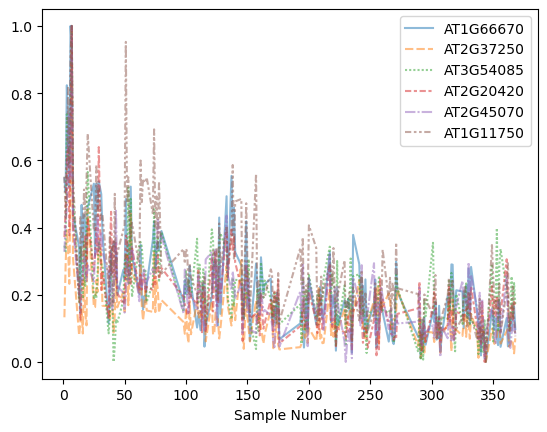

In [84]:
ax = sns.lineplot(
    data = normalized_proteasome_df,
    alpha = .5

)

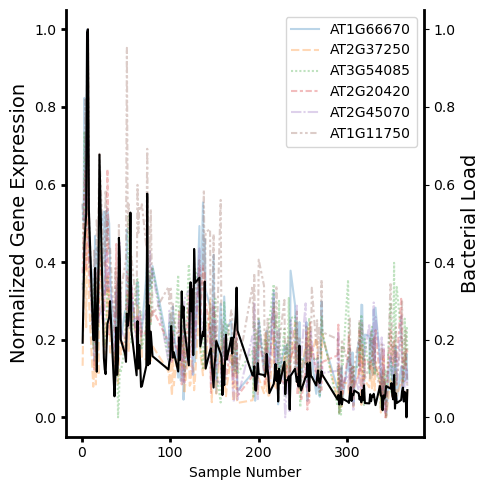

In [116]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.patch.set_facecolor("white")
ax = sns.lineplot(
    data = normalized_proteasome_df,
    alpha = .3

)
ax2 = plt.twinx()
sns.lineplot(
    x=long_term_metadata_w_load_info['Sample Number'],
    y=long_term_metadata_w_load_info['Scaled HAM16S'],
    color = 'k'

)
plt.xlabel("Sample number", fontsize=14)
plt.ylabel("Bacterial Load", fontsize=14)
ax.set_ylabel(ylabel = 'Normalized Gene Expression', fontsize = 14, color = 'k')
#sns.despine()
# ax.grid(False)
# plt.axhline(1, color = 'red', linestyle = 'dashed')
ax.spines["bottom"].set_color("black")
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_color("black")
ax.spines["left"].set_linewidth(2)
ax2.spines["right"].set_color("black")
ax2.spines["right"].set_linewidth(2)
ax.spines["top"].set_color("black")
ax.spines["top"].set_linewidth(0)
ax2.spines["top"].set_color("black")
ax2.spines["top"].set_linewidth(0)
ax.tick_params(axis="both", width=2)
# plt.xlim((0,3))
# plt.ylim((0, 3))
# handles, labels  =  ax.get_legend_handles_labels()
# ax.legend(loc="upper right")
# plt.title("Current Threshold is 31", fontsize = 20)
plt.xticks(
    fontsize=10,
)  # rotation=90
plt.yticks(fontsize=10)
# plt.ylim(-.02,1)
plt.tight_layout()
# ax.plot([0,1],[0,1], transform=ax.transAxes, linestyle = 'dashed', color = 'k', linewidth = 1.5)
# for line in range(0,full_meta_data.shape[0]):
#      ax.text(pca[:,0][line]+0.01, pca[:,1][line],
#      full_meta_data['plate.pos'][line], horizontalalignment='left',
#      size='medium', color='black', weight='semibold')
plt.savefig('/Users/michael/Data/Luke_terrace_experiment/Output_for_Luke/Figs/6_interesting_genes_proteasome.pdf')


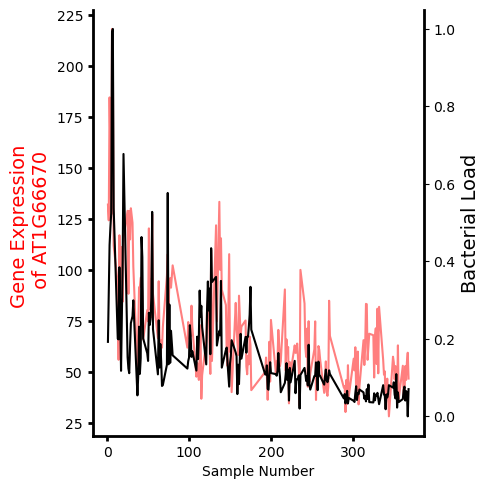

In [109]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.patch.set_facecolor("white")
ax = sns.lineplot(
    x=long_term_metadata_w_load_info['Sample Number'],
    y=long_term_transcriptome['AT1G66670'],
    color = 'r',
    alpha = .5

)
ax2 = plt.twinx()
sns.lineplot(
    x=long_term_metadata_w_load_info['Sample Number'],
    y=long_term_metadata_w_load_info['Scaled HAM16S'],
    color = 'k'

)
plt.xlabel("Sample number", fontsize=14)
plt.ylabel("Bacterial Load", fontsize=14)
ax.set_ylabel(ylabel = 'Gene Expression \n of AT1G66670', fontsize = 14, color = 'r')
#sns.despine()
# ax.grid(False)
# plt.axhline(1, color = 'red', linestyle = 'dashed')
ax.spines["bottom"].set_color("black")
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_color("black")
ax.spines["left"].set_linewidth(2)
ax2.spines["right"].set_color("black")
ax2.spines["right"].set_linewidth(2)
ax.spines["top"].set_color("black")
ax.spines["top"].set_linewidth(0)
ax2.spines["top"].set_color("black")
ax2.spines["top"].set_linewidth(0)
ax.tick_params(axis="both", width=2)
# plt.xlim((0,3))
# plt.ylim((0, 3))
# handles, labels  =  ax.get_legend_handles_labels()
# ax.legend(loc="upper right")
# plt.title("Current Threshold is 31", fontsize = 20)
plt.xticks(
    fontsize=10,
)  # rotation=90
plt.yticks(fontsize=10)
# plt.ylim(-.02,1)
plt.tight_layout()
# ax.plot([0,1],[0,1], transform=ax.transAxes, linestyle = 'dashed', color = 'k', linewidth = 1.5)
# for line in range(0,full_meta_data.shape[0]):
#      ax.text(pca[:,0][line]+0.01, pca[:,1][line],
#      full_meta_data['plate.pos'][line], horizontalalignment='left',
#      size='medium', color='black', weight='semibold')
plt.savefig('/Users/michael/Data/Luke_terrace_experiment/Output_for_Luke/Figs/single_proteasome_gene_expression.pdf')


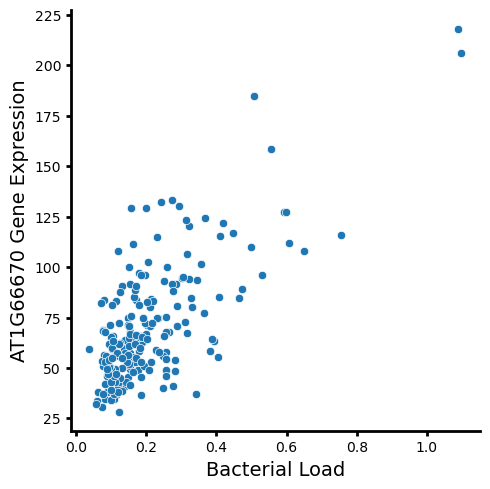

In [111]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.patch.set_facecolor("white")
ax = sns.scatterplot(
    x=long_term_metadata_w_load_info['ham16s'],
    y=long_term_transcriptome['AT1G66670'],

)
plt.xlabel("Bacterial Load", fontsize=14)
plt.ylabel("AT1G66670 Gene Expression", fontsize=14)
sns.despine()
# ax.grid(False)
# plt.axhline(1, color = 'red', linestyle = 'dashed')
ax.spines["bottom"].set_color("black")
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_color("black")
ax.spines["left"].set_linewidth(2)
ax.tick_params(axis="both", width=2)
# plt.xlim((0,3))
# plt.ylim((0, 3))
# handles, labels  =  ax.get_legend_handles_labels()
# ax.legend(loc="upper right")
# plt.title("Current Threshold is 31", fontsize = 20)
plt.xticks(
    fontsize=10,
)  # rotation=90
plt.yticks(fontsize=10)
# plt.ylim(-.02,1)
plt.tight_layout()
# ax.plot([0,1],[0,1], transform=ax.transAxes, linestyle = 'dashed', color = 'k', linewidth = 1.5)
# for line in range(0,full_meta_data.shape[0]):
#      ax.text(pca[:,0][line]+0.01, pca[:,1][line],
#      full_meta_data['plate.pos'][line], horizontalalignment='left',
#      size='medium', color='black', weight='semibold')
plt.savefig('/Users/michael/Data/Luke_terrace_experiment/Output_for_Luke/Figs/bacterial_load_vs_Gene_expression_directly.pdf')


In [ ]:
## bacterially correlated genes

In [25]:
go_annotations_arabi = pd.read_csv('/Users/michael/Data/Reference_data/Arabdidopsis_go_matrix_from_tair_gaf.csv', index_col=0)
go_annotations_arabi

,GO:0000001,GO:0000009,GO:0000012,GO:0000014,GO:0000023,GO:0000024,GO:0000025,GO:0000026,GO:0000027,GO:0000028,...,GO:2001071,GO:2001080,GO:2001141,GO:2001142,GO:2001143,GO:2001147,GO:2001227,GO:2001280,GO:2001289,GO:2001294
GeneID,,,,,,,,,,,,,,,,,,,,,
AT1G01010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT5G67600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT5G67610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT5G67620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
remove_bad_sized_go_groups = go_annotations_arabi.loc[:, (go_annotations_arabi.sum() > 5) & (go_annotations_arabi.sum() < 500)]
remove_bad_sized_go_groups

,GO:0000014,GO:0000036,GO:0000038,GO:0000045,GO:0000049,GO:0000062,GO:0000103,GO:0000104,GO:0000105,GO:0000118,...,GO:2000280,GO:2000306,GO:2000377,GO:2000652,GO:2000762,GO:2000904,GO:2001006,GO:2001009,GO:2001070,GO:2001289
GeneID,,,,,,,,,,,,,,,,,,,,,
AT1G01010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT5G67600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT5G67610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT5G67620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
spearman_go_tables = generate_contigency_tables(go_annotations= remove_bad_sized_go_groups, gene_list=spearman_top_100, use_background_genes=True, background_genes=background_gene_list)
spearman_results = fishers_exact_on_contigency_tables(spearman_go_tables, remove_bad_sized_go_groups)
corrected_spearman_results = multi_hypothesis_correct_fishers_exact(spearman_results)


In [28]:
corrected_spearman_results.sort_values(by='P_value').head(20)

,P_value
GO:0022626,1.876996e-13
GO:0005730,5.082956e-11
GO:0022625,4.925101e-10
GO:0022627,2.996107e-06
GO:0009532,1.160178e-04
GO:0005507,8.559663e-03
GO:0000502,1.229500e-02
GO:0005839,2.804969e-02
GO:0005773,4.357108e-02
GO:0009955,4.357108e-02


In [29]:
pearson_go_tables = generate_contigency_tables(go_annotations= remove_bad_sized_go_groups, gene_list=pearson_top_100, use_background_genes=True, background_genes=background_gene_list)
pearson_results = fishers_exact_on_contigency_tables(pearson_go_tables, remove_bad_sized_go_groups)
corrected_pearson_results = multi_hypothesis_correct_fishers_exact(pearson_results)


In [30]:
corrected_pearson_results.sort_values(by='P_value').head(20)

,P_value
GO:0000502,3.133514e-15
GO:0005839,2.426815e-11
GO:0006511,3.470580e-07
GO:0019774,7.539707e-07
GO:0045271,1.356365e-05
GO:0019773,6.806409e-05
GO:0034976,8.286986e-05
GO:0099503,1.841542e-04
GO:0009505,4.202007e-04
GO:0005507,7.207259e-04


In [31]:
pearson_correlation_with_load_its = cleaned_long_term_transcriptome.corrwith(long_term_metadata_w_load_info['hamits'])
spearman_correlation_with_load_its = cleaned_long_term_transcriptome.corrwith(long_term_metadata_w_load_info['hamits'], method='spearman')


In [37]:
spearman_correlation_with_load_its.sort_values(ascending = False).head(200)

AT2G43570    0.535625
AT2G15220    0.525911
AT5G14030    0.523675
AT1G30230    0.509835
AT4G02450    0.503378
               ...   
AT5G10360    0.420171
AT4G11650    0.420024
AT5G66510    0.419852
AT3G27430    0.419710
AT5G23140    0.419631
Length: 200, dtype: float64

In [ ]:
spearman_top_100_its = spearman_correlation_with_load_its.sort_values(ascending=False).head(200).index.to_list()
pearson_top_100_its = pearson_correlation_with_load_its.sort_values(ascending=False).head(200).index.to_list()

In [48]:
spearman_go_tables_its = generate_contigency_tables(go_annotations= remove_bad_sized_go_groups, gene_list=spearman_top_100_its, use_background_genes=True, background_genes=background_gene_list)
spearman_results_its = fishers_exact_on_contigency_tables(spearman_go_tables_its, remove_bad_sized_go_groups)
corrected_spearman_results_its = multi_hypothesis_correct_fishers_exact(spearman_results_its)

pearson_go_tables_its = generate_contigency_tables(go_annotations= remove_bad_sized_go_groups, gene_list=pearson_top_100_its, use_background_genes=True, background_genes=background_gene_list)
pearson_results_its = fishers_exact_on_contigency_tables(pearson_go_tables_its, remove_bad_sized_go_groups)
corrected_pearson_results_its = multi_hypothesis_correct_fishers_exact(pearson_results_its)


In [49]:
corrected_spearman_results_its.sort_values(by='P_value').head(20)

,P_value
GO:0022626,4.710360e-22
GO:0022625,2.353842e-19
GO:0099503,7.365431e-10
GO:0005773,1.220460e-08
GO:0005730,1.190390e-04
GO:0010494,6.122846e-03
GO:0009955,7.240674e-03
GO:0005507,3.035890e-02
GO:0009505,3.048845e-02
GO:0022627,3.048845e-02


In [50]:
corrected_pearson_results_its.sort_values(by='P_value').head(20)

,P_value
GO:0005773,0.000602
GO:0000502,0.000800
GO:0005839,0.004946
GO:0005788,0.014687
GO:0006511,0.014687
GO:0019773,0.015344
GO:0099503,0.016593
GO:0034976,0.078263
GO:0006457,0.078263
GO:0030163,0.090635
